# it's time to try defining entropy


1. created script [select_rois_for_entropycalc.py](select_rois_for_entropycalc.py) to select 16 ROIs in the maze
   1. an alternative would just be using a grid but we can also explore that later
2. extract number of frames in hte different ROIs (time spent per visit here is going to be in frames but the video is 30fps so we can deal with the maths later)
3. calculate $- log(p_{ROI_{i}})$
4. spatial entropy 

$$H = - \sum p_i log(p_i)$$

- $p_{i}$ will be calculated as time spent in roi, and another calculation with probability per visitation count. 
- but realistically we don't really have to calculate the TIME, what about frames occupied within the ROI as an approximate for time? Yes? Approximate? Alright



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os


In [ ]:

# get the entropy after getting the probabilities for each ROI in terms of time spent in roi (time as frames)

dlc_df = pd.read_csv('C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/mouse 6357/deeplabcut/mouse6357/mouse6357-shahd-2025-09-08/videos/6357_2024-08-28_11_58_14s3.6DLC_Resnet50_mouse6357Sep8shuffle1_snapshot_200.csv', 
                     header=[0, 1, 2], index_col=0)
trials_df = pd.read_csv("C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/mouse 6357/2024-08-28_11_58_146357session3.6/trajectories_maze_video_back_mid_v2/trials_with_metrics_matched.csv")
rois_for_entropy_df = pd.read_csv("C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/mouse 6357/2024-08-28_11_58_146357session3.6/rois_for_entropy.csv")

rois ={}
for _,row in rois_for_entropy_df.iterrows():
    rois[row['ROI_Name']] = (row['x_min'], row['x_max'], row['y_min'], row['y_max'])

print(f"Loaded {len(rois)} ROIs from csv.")


def analyse_trial_rois(trial_idx, dlc_df, trials_df, rois):
    # Get start/end frames for the specific trial
    start_f = int(trials_df.loc[trial_idx, 'start_frame'])
    end_f = int(trials_df.loc[trial_idx, 'end_frame'])
    
    # Extract tracking data for 'mid' bodypart
    scorer = dlc_df.columns.levels[0][0]
    x = dlc_df.loc[start_f:end_f, (scorer, 'mid', 'x')].values
    y = dlc_df.loc[start_f:end_f, (scorer, 'mid', 'y')].values
    
    # Initialize results
    roi_stats = {name: {'frames': 0, 'visits': 0} for name in rois}
    in_roi_prev = {name: False for name in rois} # Track previous state for entrance detection
    
    # Loop through every frame in the trial
    for xi, yi in zip(x, y):
        if np.isnan(xi) or np.isnan(yi):
            continue
            
        for name, (x1, x2, y1, y2) in rois.items():
            # Check if mouse is inside this ROI
            is_inside = (x1 <= xi < x2) and (y1 <= yi < y2)
            
            if is_inside:
                roi_stats[name]['frames'] += 1
                
                # If it wasn't inside previously, this is a new visit
                if not in_roi_prev[name]:
                    roi_stats[name]['visits'] += 1
            
            in_roi_prev[name] = is_inside
            
    return roi_stats


Loaded 16 ROIs from csv.


In [ ]:
# Prova: Run Analysis on Trial 0

stats = analyse_trial_rois(0, dlc_df, trials_df, rois)

# 4. Calculate Entropy
total_frames = sum(s['frames'] for s in stats.values())
probabilities = []

print(f"{'ROI Name':<15} | {'Time (frames)':<15} | {'Visits':<10} | {'Prob (P)':<10}")
print("-" * 60)

for name, metrics in stats.items():
    p = metrics['frames'] / total_frames if total_frames > 0 else 0
    if p > 0:
        probabilities.append(p)
    print(f"{name:<15} | {metrics['frames']:<15} | {metrics['visits']:<10} | {p:.4f}")

# Shannon Entropy Calculation
# H = -sum(p * log2(p))
entropy = -np.sum(np.array(probabilities) * np.log2(probabilities)) if probabilities else 0
print(f"\nSpatial Entropy: {entropy:.4f} bits")




ROI Name        | Time (frames)   | Visits     | Prob (P)  
------------------------------------------------------------
Zone_1          | 30              | 1          | 0.0208
Zone_2          | 28              | 2          | 0.0195
Zone_3          | 67              | 2          | 0.0466
Zone_4          | 92              | 6          | 0.0639
Zone_5          | 49              | 4          | 0.0341
Zone_6          | 90              | 6          | 0.0625
Zone_7          | 55              | 5          | 0.0382
Zone_8          | 14              | 2          | 0.0097
Zone_9          | 44              | 1          | 0.0306
Zone_10         | 215             | 1          | 0.1494
Zone_11         | 80              | 4          | 0.0556
Zone_12         | 208             | 8          | 0.1445
Zone_13         | 33              | 3          | 0.0229
Zone_14         | 33              | 4          | 0.0229
Zone_15         | 336             | 3          | 0.2335
Zone_16         | 65              | 1  

We can get the time (in seconds) by dividing the number of frames by 30. Should also look into running this for all the trials and make a df where columns are ROIs and rows are time spent but maybe that's just unnecessary

below we calculate the entropy for all the trials and save them into a new .csv file called `trials_with_entropy.csv`

In [51]:


base_path = r"C:/Users/aleja/Box/Awake Project/Maze data/simplermaze/mouse 6357"


dlc_path = f"{base_path}/deeplabcut/mouse6357/mouse6357-shahd-2025-09-08/videos/6357_2024-08-28_11_58_14s3.6DLC_Resnet50_mouse6357Sep8shuffle1_snapshot_200.csv"
dlc_df = pd.read_csv(dlc_path, header=[0, 1, 2], index_col=0)


trials_path = f"{base_path}/2024-08-28_11_58_146357session3.6/trajectories_maze_video_back_mid_v2/trials_with_metrics_matched.csv"
trials_df = pd.read_csv(trials_path)


rois_path = f"{base_path}/2024-08-28_11_58_146357session3.6/rois_for_entropy.csv" 
roi_df = pd.read_csv(rois_path)

# Convert ROIs to dictionary for faster lookup
rois = {}
for _, row in roi_df.iterrows():
    rois[row['ROI_Name']] = (row['x_min'], row['x_max'], row['y_min'], row['y_max'])

print(f"Loaded {len(rois)} ROIs.")

#before we do anything we need to filter out the estimations with low confidence (evidence, check entropy plots with no threshold)

def get_cleaned_trajectory(start_f, end_f, dlc_df, bodypart='back_mid', p_cutoff=0.8):
    """
    Extracts coordinates, filters low likelihood frames, and interpolates.
    """
    if np.isnan(start_f) or np.isnan(end_f):
        return np.array([]), np.array([])
        
    start_f, end_f = int(start_f), int(end_f)
    scorer = dlc_df.columns.levels[0][0]
    
    # Check if bodypart exists
    if bodypart not in dlc_df.columns.levels[1]:
        # Fallback to 'mid' or 'body' if 'back_mid' is missing, or raise error
        print(f"Warning: {bodypart} not found. Checking for 'mid'...")
        if 'mid' in dlc_df.columns.levels[1]:
            bodypart = 'mid'
        else:
            return np.array([]), np.array([])

    try:
        # Extract data
        subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
        x = subset['x']
        y = subset['y']
        prob = subset['likelihood']
        
        # Filter: Set low likelihood points to NaN
        mask = prob < p_cutoff
        x[mask] = np.nan
        y[mask] = np.nan
        
        # Interpolate to fill gaps
        x_clean = x.interpolate(method='linear', limit_direction='both').values
        y_clean = y.interpolate(method='linear', limit_direction='both').values
        
        return x_clean, y_clean
    except KeyError:
        return np.array([]), np.array([])


def calculate_trial_entropy(trial_row, dlc_df, rois):
    """
    Calculates spatial entropy for a single trial row.
    Returns: Entropy value (float)
    """
    start_f = trial_row['start_frame']
    end_f = trial_row['end_frame']
    
    if np.isnan(start_f) or np.isnan(end_f):
        return np.nan
        
    start_f, end_f = int(start_f), int(end_f)
    
    # Extract tracking data (using 'back_mid' bodypart)
    # scorer = dlc_df.columns.levels[0][0]
    # x = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'x')].values
    # y = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'y')].values
    x, y = get_cleaned_trajectory(start_f, end_f, dlc_df, bodypart='back_mid', p_cutoff=0.8)
    
    # Count frames in each ROI
    # Initialise counts to 0
    roi_counts = {name: 0 for name in rois}
    total_valid_frames = 0
    
    for xi, yi in zip(x, y):
        if np.isnan(xi) or np.isnan(yi):
            continue
        
        # Check which ROI this point belongs to
        # Note: A point can be in multiple ROIs if they overlap
        for name, (x1, x2, y1, y2) in rois.items():
            if (x1 <= xi < x2) and (y1 <= yi < y2):
                roi_counts[name] += 1
                total_valid_frames += 1
    
    if total_valid_frames == 0:
        return 0.0

    # Calculate Probability pi
    # P(i) = (Time in ROI i) / (Total Time in any ROI)
    # so for p(ROI1) for example, it would be time in ROI1 /time in all the ROIs.

    # Usually, relative to total_valid_frames is safer for entropy.
    probs = []
    for count in roi_counts.values():
        p = count / total_valid_frames
        if p > 0:
            probs.append(p)
    
    # Shannon Entropy: H = -sum(p * log2(p))
    if not probs:
        return 0.0
        
    return -np.sum(np.array(probs) * np.log2(probs))


#calculate the entropy for all the trials
print("Calculating entropy for all trials...")

# Apply function to every row in trials_df
# axis=1 passes the row to the function
trials_df['spatial_entropy'] = trials_df.apply(
    lambda row: calculate_trial_entropy(row, dlc_df, rois), axis=1
)

# Show result
print(trials_df[['matched_trial_id', 'spatial_entropy']].head())

# Save updated CSV
trials_df.to_csv(f"{base_path}/2024-08-28_11_58_146357session3.6/trials_with_entropy.csv", index=False)
print("Saved results to trials_with_entropy.csv")

Loaded 16 ROIs.
Calculating entropy for all trials...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer

  matched_trial_id  spatial_entropy
0        trial_000         3.493031
1        trial_001         0.985228
2        trial_002         2.153192
3        trial_003         2.301694
4              NaN              NaN
Saved results to trials_with_entropy.csv


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2908389764.py:45: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer

below is le visualisation functions, we are going to plot these as heatmaps

In [47]:
def get_cleaned_trajectory(trial_row, dlc_df, bodypart='back_mid', p_cutoff=0.8):
    """
    Helper function: Extracts coordinates, filters low likelihood frames, 
    and interpolates missing data.
    """
    start_f = trial_row['start_frame']
    end_f = trial_row['end_frame']
    
    if np.isnan(start_f) or np.isnan(end_f):
        return np.array([]), np.array([])
        
    start_f, end_f = int(start_f), int(end_f)
    scorer = dlc_df.columns.levels[0][0]
    
    # 1. Extract Data safely
    try:
        # Copy to avoid SettingWithCopyWarning
        subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
    except KeyError:
        return np.array([]), np.array([])
    
    x = subset['x']
    y = subset['y']
    prob = subset['likelihood']
    
    # 2. Filter: Set coordinates to NaN where likelihood is too low
    # We use .loc to ensure we are modifying the Series correctly
    mask = prob < p_cutoff
    x[mask] = np.nan
    y[mask] = np.nan
    
    # 3. Interpolate: Fill NaNs linearly
    # limit_direction='both' ensures we fill edges if the trial starts/ends with low prob
    x_clean = x.interpolate(method='linear', limit_direction='both').values
    y_clean = y.interpolate(method='linear', limit_direction='both').values
    
    return x_clean, y_clean

# def get_roi_probabilities(trial_row, dlc_df, rois):
#     """
#     Re-calculates time spent in each ROI for a specific trial to determine colors.
#     """
#     start_f = trial_row['start_frame']
#     end_f = trial_row['end_frame']
    
#     if np.isnan(start_f) or np.isnan(end_f):
#         return {}
        
#     start_f, end_f = int(start_f), int(end_f)
    
#     # Extract tracking data ('back_mid', all, no threshold)
#     scorer = dlc_df.columns.levels[0][0]
#     x = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'x')].values
#     y = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'y')].values
    
#     roi_counts = {name: 0 for name in rois}
#     total_valid_frames = 0
    
#     for xi, yi in zip(x, y):
#         if np.isnan(xi) or np.isnan(yi):
#             continue
            
#         for name, (x1, x2, y1, y2) in rois.items():
#             if (x1 <= xi < x2) and (y1 <= yi < y2):
#                 roi_counts[name] += 1
#                 total_valid_frames += 1

#     # Calculate Probabilities (P)
#     probs = {}
#     if total_valid_frames > 0:
#         for name, count in roi_counts.items():
#             probs[name] = count / total_valid_frames
    
#     return probs


def get_roi_probabilities(trial_row, dlc_df, rois):
    """
    Re-calculates time spent using CLEANED (interpolated) data.
    """
    # Use the helper function here!
    x, y = get_cleaned_trajectory(trial_row, dlc_df, p_cutoff=0.8)
    
    if len(x) == 0:
        return {}
        
    roi_counts = {name: 0 for name in rois}
    total_valid_frames = 0
    
    for xi, yi in zip(x, y):
        # Even after interpolation, check for NaNs (e.g., if whole trial was bad)
        if np.isnan(xi) or np.isnan(yi):
            continue
            
        for name, (x1, x2, y1, y2) in rois.items():
            if (x1 <= xi < x2) and (y1 <= yi < y2):
                roi_counts[name] += 1
                total_valid_frames += 1

    # Calculate Probabilities (P)
    probs = {}
    if total_valid_frames > 0:
        for name, count in roi_counts.items():
            probs[name] = count / total_valid_frames
    
    return probs

def plot_spatial_heatmap(trial_index, trials_df, dlc_df, rois):
    # Get the row for this trial
    row = trials_df.loc[trial_index]
    
    # 1. Get Probabilities for coloring
    roi_probs = get_roi_probabilities(row, dlc_df, rois)
    
    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Setup Colormap (White -> Blue -> Purple)
    # Vmax is set to 0.5 (50% time) to make lower probabilities visible. 
    # You can change vmax to 1.0 if you want absolute scaling.
    cmap = cm.get_cmap('Purples') 
    norm = mcolors.Normalize(vmin=0, vmax=0.5) 

    # 3. Draw ROIs
    for name, (x1, x2, y1, y2) in rois.items():
        width = x2 - x1
        height = y2 - y1
        
        # Get probability (default to 0 if not visited)
        p = roi_probs.get(name, 0)
        
        # Determine color
        color = cmap(norm(p))
        
        # Draw Rectangle
        # Alpha is 0.7 so we can see the grid lines/overlaps slightly
        rect = patches.Rectangle((x1, y1), width, height, 
                                 linewidth=1, edgecolor='gray', facecolor=color, alpha=0.8)
        ax.add_patch(rect)
        
        # # Optional: Add text showing the probability % inside the box
        # if p > 0.01: # Only show if > 1%
        ax.text(x1 + width/2, y1 + height/2, f"{p*100:.2f}%", 
                ha='center', va='center', fontsize=8, color='black')

    # 4. Overlay Trajectory (Red Line)
    start_f, end_f = int(row['start_frame']), int(row['end_frame'])
    scorer = dlc_df.columns.levels[0][0]
    # x_traj = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'x')]
    # y_traj = dlc_df.loc[start_f:end_f, (scorer, 'back_mid', 'y')]
    x_traj, y_traj = get_cleaned_trajectory(row, dlc_df, p_cutoff=0.8)
    
    ax.plot(x_traj, y_traj, color='orange', linewidth=2, alpha=0.6, label='Mouse Path')


    # Retrieve the pre-calculated entropy from le CSV
    entropy_val = row['spatial_entropy']
    raw_seq = str(row['state_sequence'])
    state_sequence_dict = {"1": "explore", "2":"exploit", "3":"nest", "4":"groom"}
    trial_id = row['matched_trial_id']

    #handle the mess with the "state_sequence" column in the df
    seq_str = "None"
    seq_for_title = "None"
    if raw_seq.lower() != 'nan':
        # Split by comma to avoid reading "," as a key
        parts = [p.strip() for p in raw_seq.split(',')]
        # Map valid keys only
        mapped_parts = [state_sequence_dict.get(p, p) for p in parts if p in state_sequence_dict]
        if mapped_parts:
            seq_str = " -> ".join(mapped_parts)
            seq_for_title= "_".join(mapped_parts)
    
    ax.set_title(f"Trial: {trial_id} | Entropy: {entropy_val:.3f} bits, | Sequence of states: {seq_str}" , fontsize=14)
    ax.set_xlabel("X coordinates")
    ax.set_ylabel("Y coordinates")
    ax.invert_yaxis() # Match video coordinates (0,0 is top-left)
    ax.set_aspect('equal')
    
    # Adjust zoom to fit all ROIs
    all_x = [c[0] for c in rois.values()] + [c[1] for c in rois.values()]
    all_y = [c[2] for c in rois.values()] + [c[3] for c in rois.values()]
    ax.set_xlim(min(all_x)-50, max(all_x)+50)
    ax.set_ylim(max(all_y)+50, min(all_y)-50) # Inverted Y axis

    # Add Colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Probability (Time Spent)', rotation=270, labelpad=15)
    
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()



Plotting Trial 0...
skipping 40 because it is null
skipping 41 because it is null


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc

MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

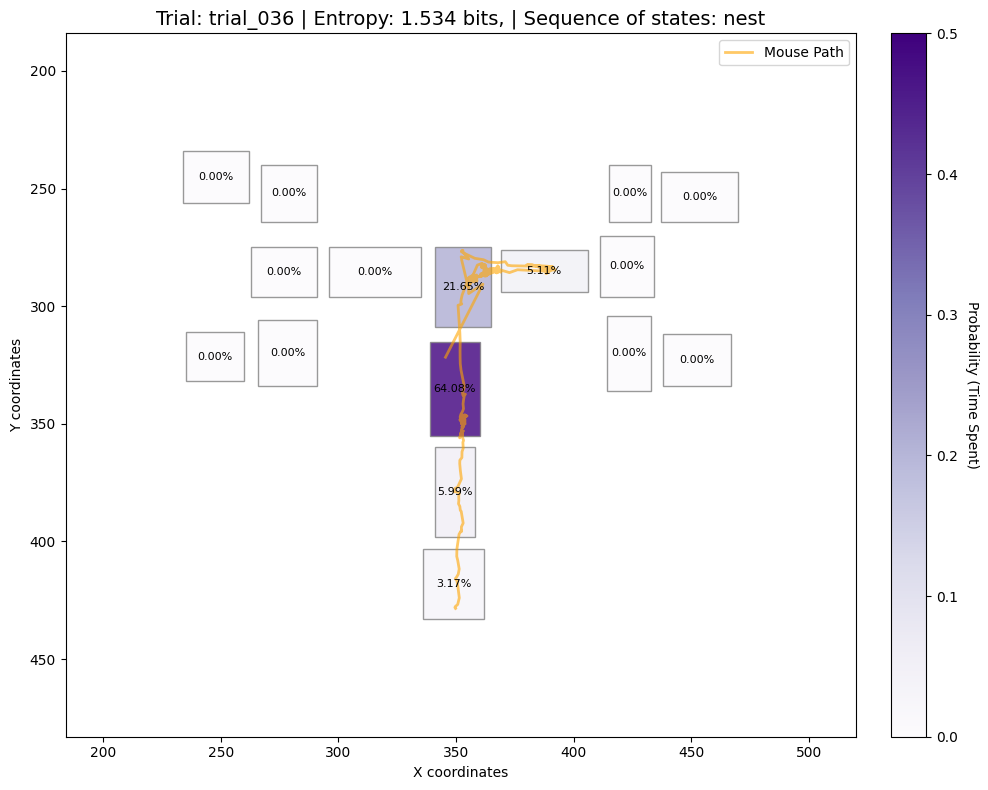

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc

skipping 43 because it is null
skipping 44 because it is null


MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

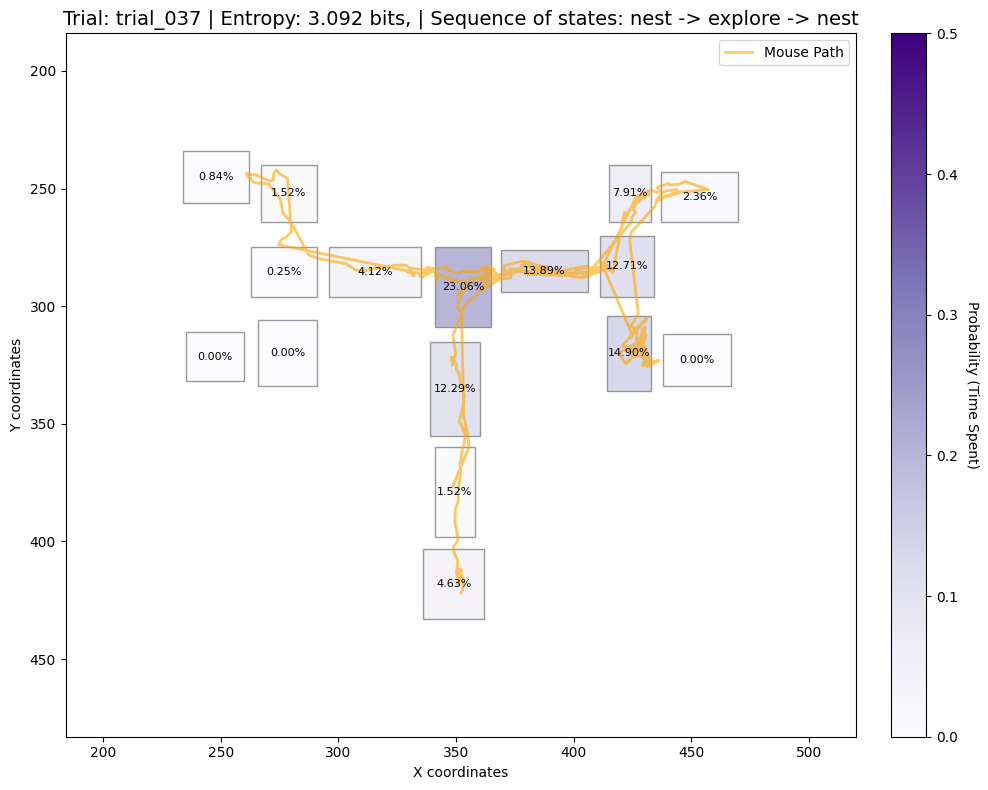

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


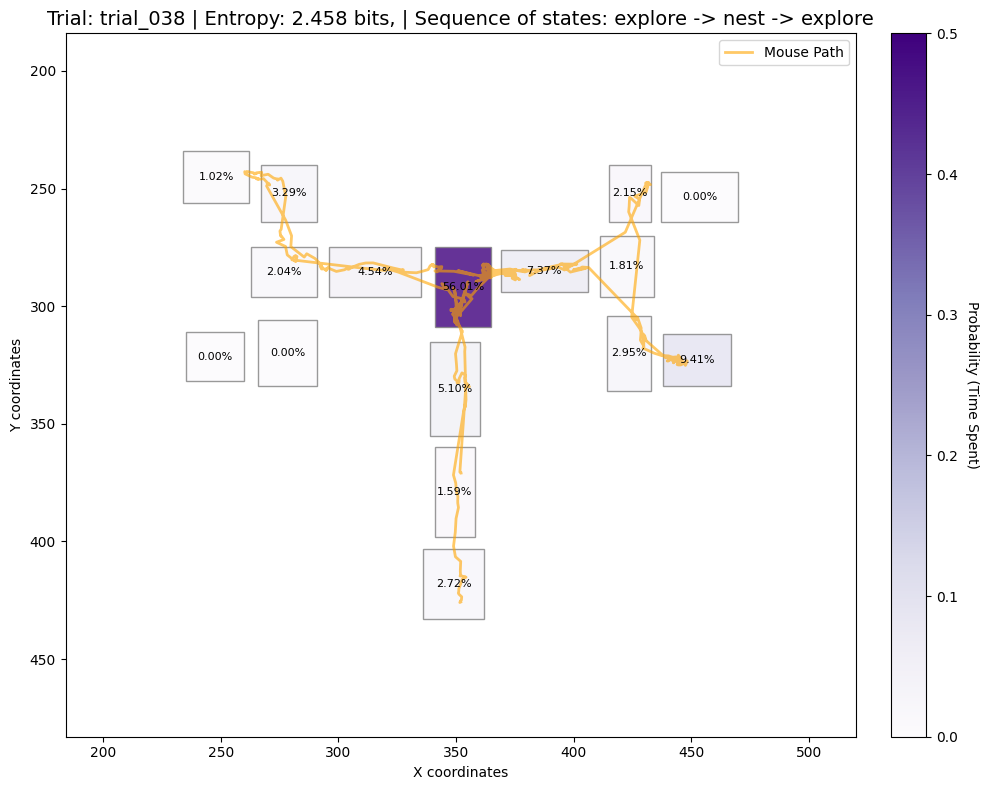

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


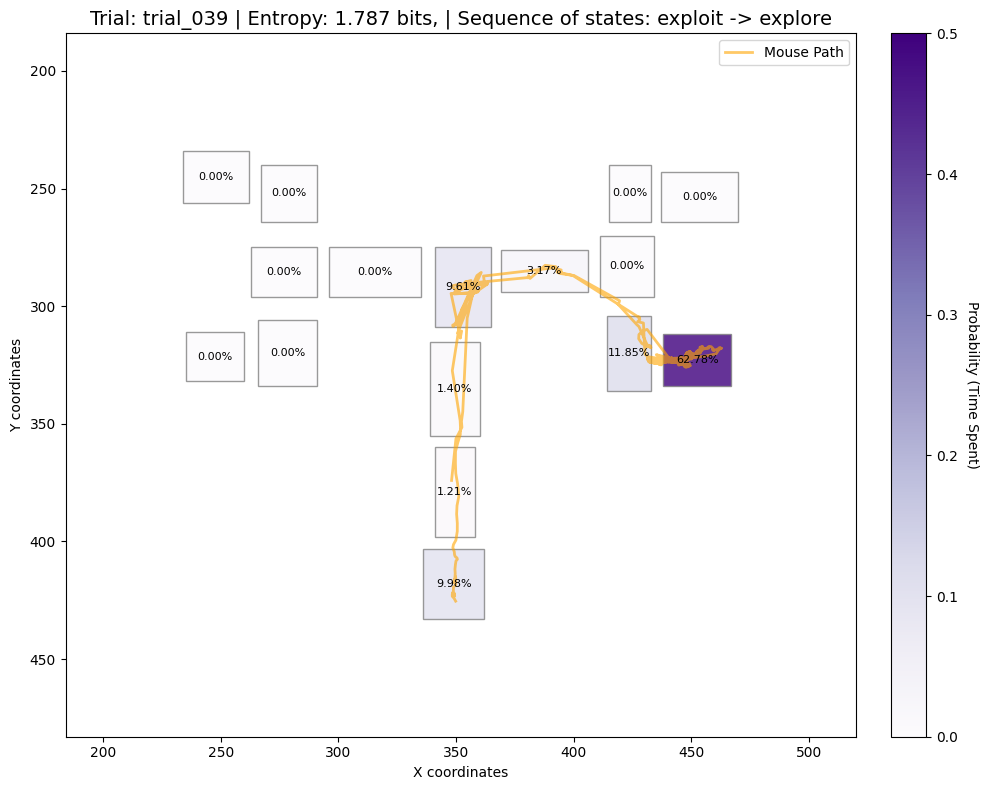

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


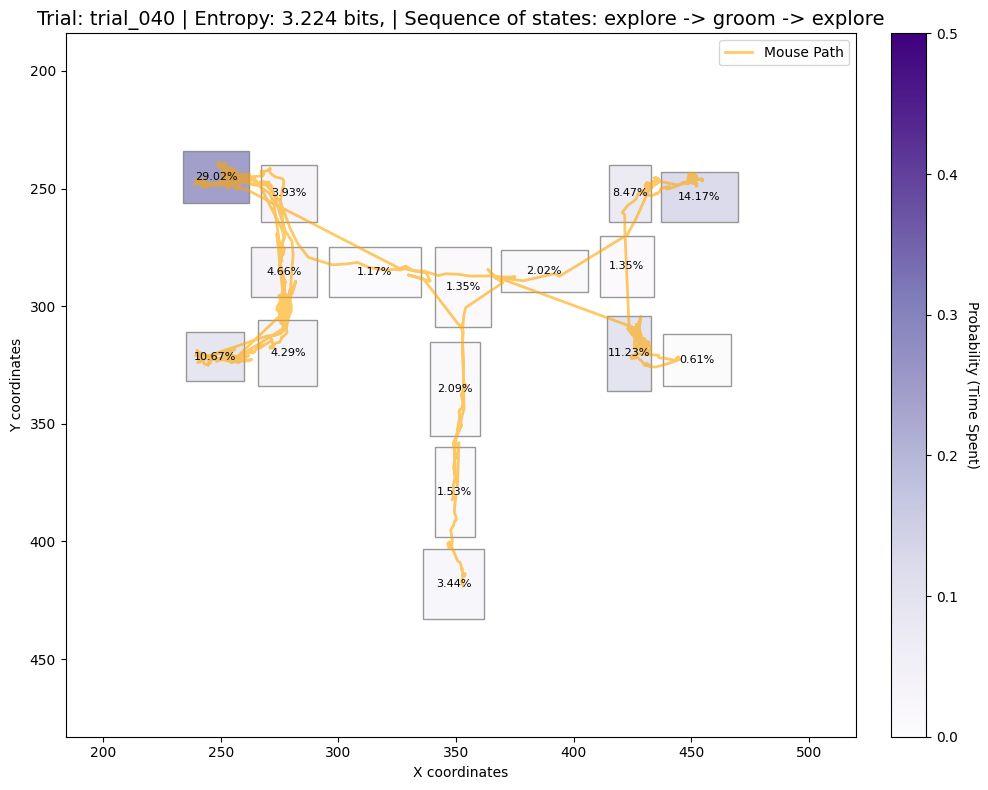

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


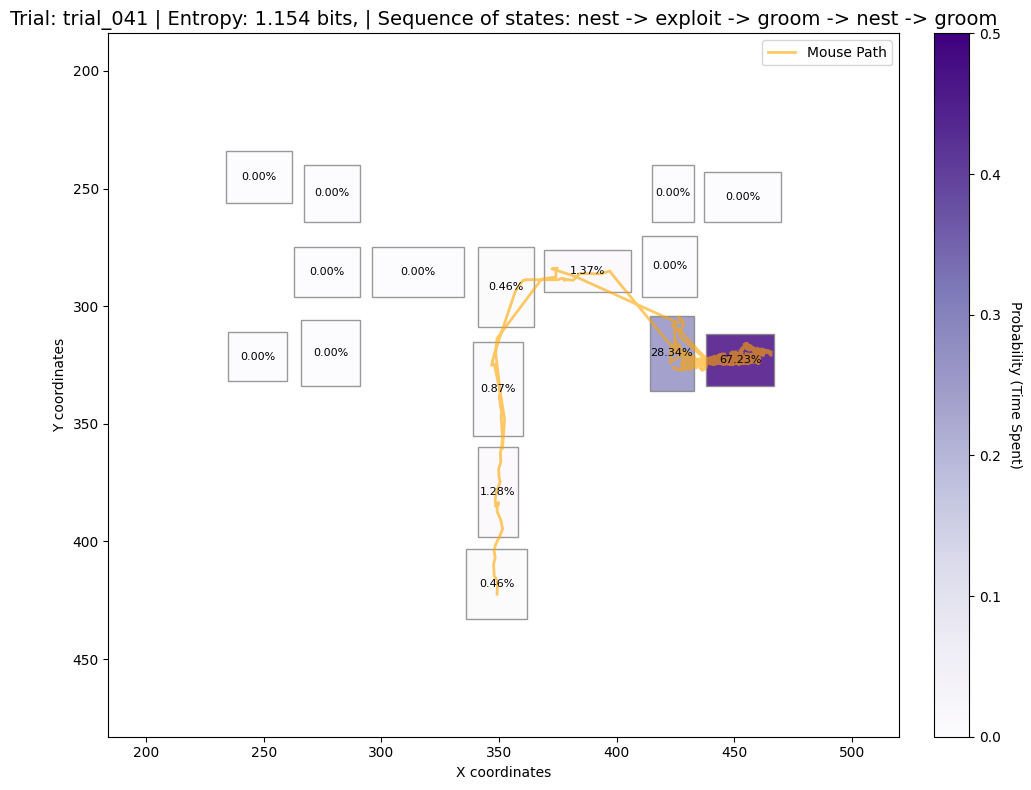

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc

skipping 50 because it is null


MemoryError: bad allocation

<Figure size 1000x800 with 1 Axes>

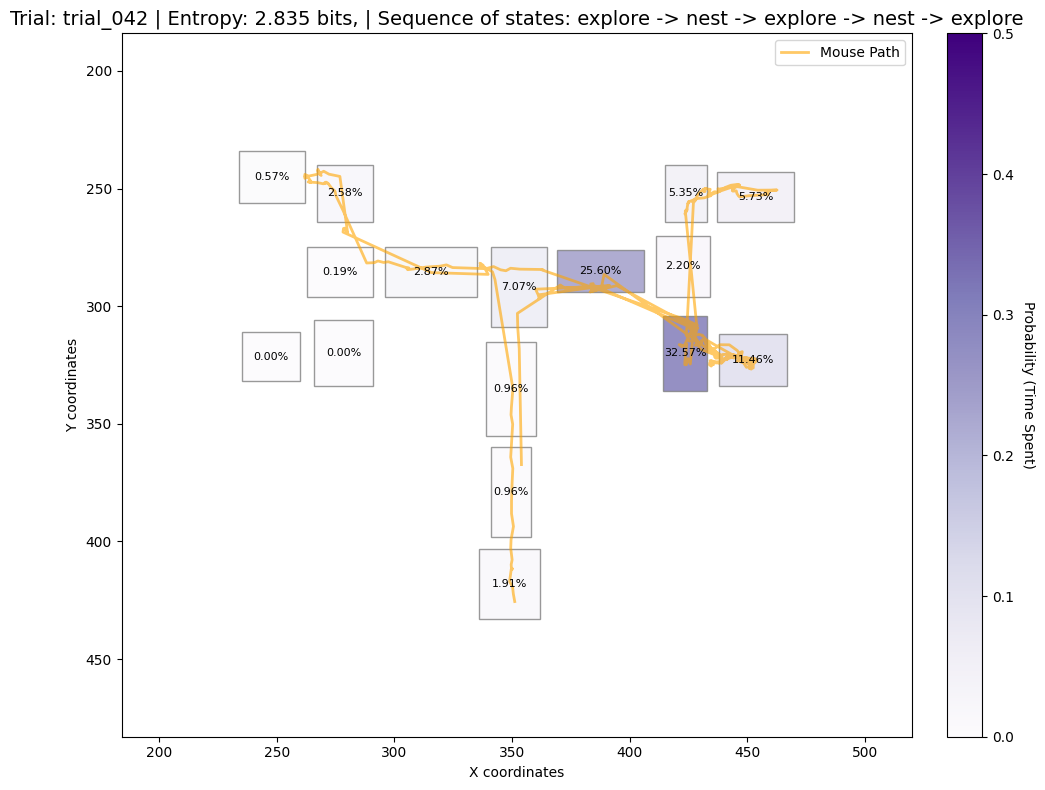

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


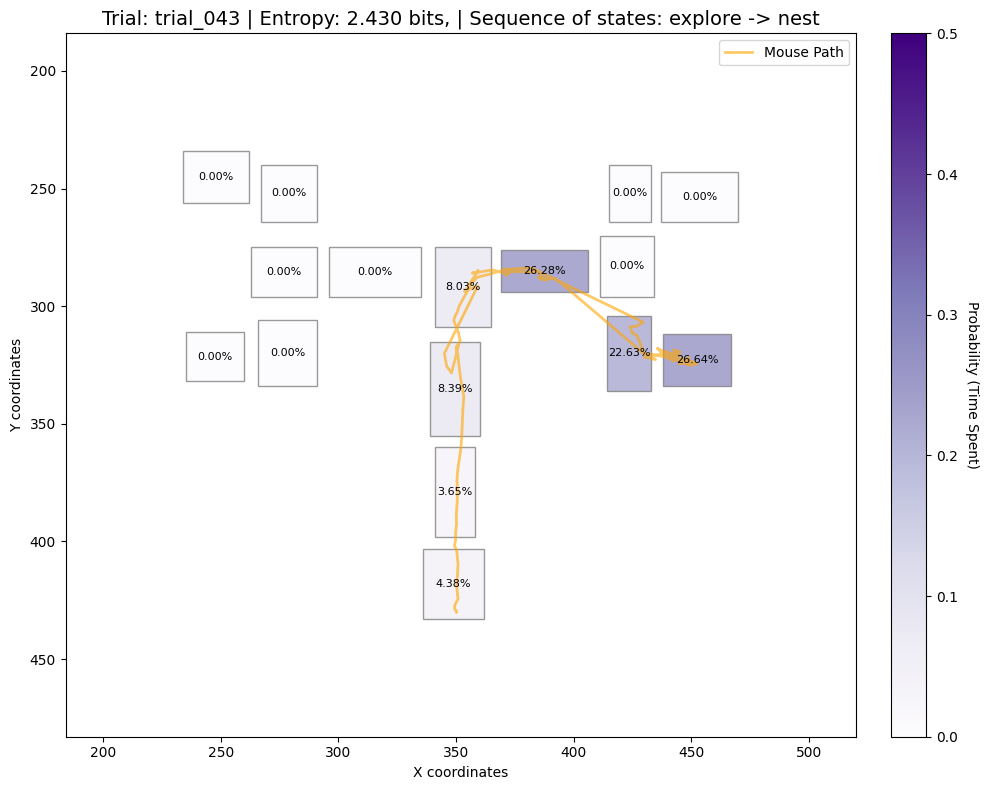

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


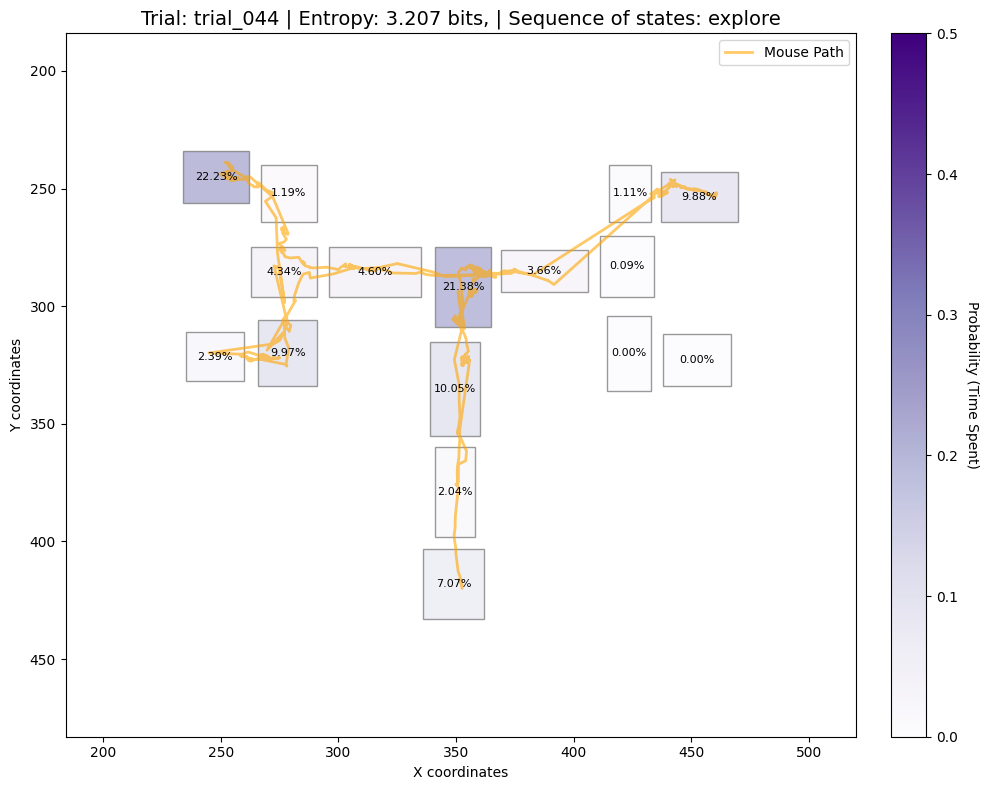

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


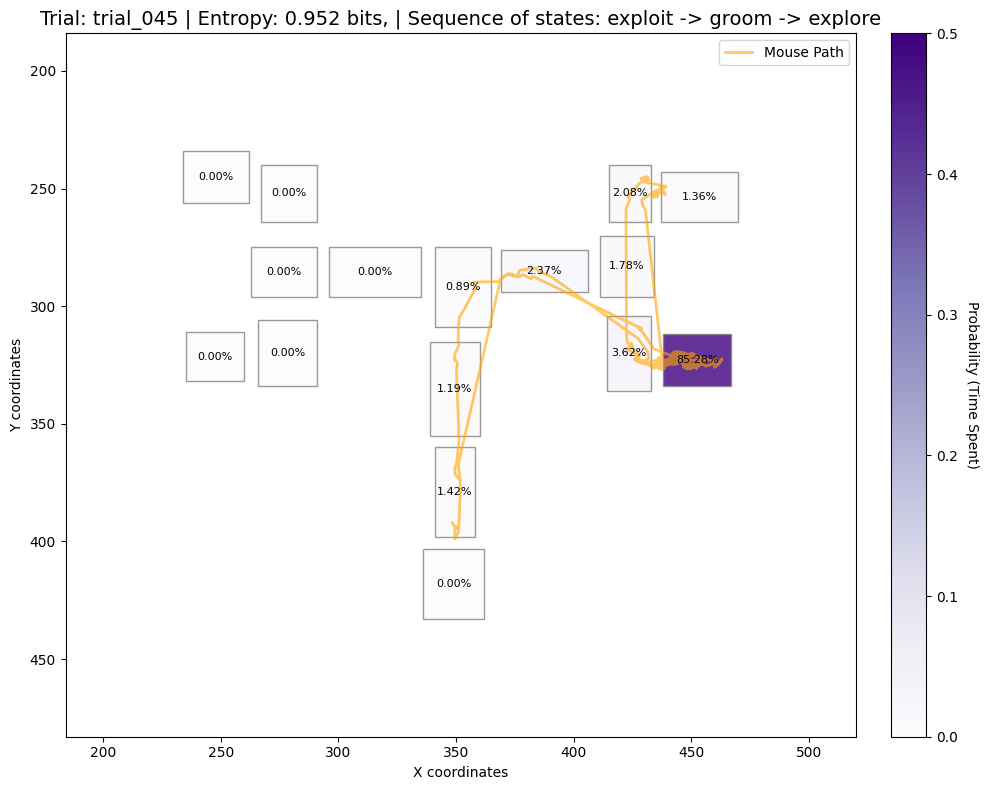

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


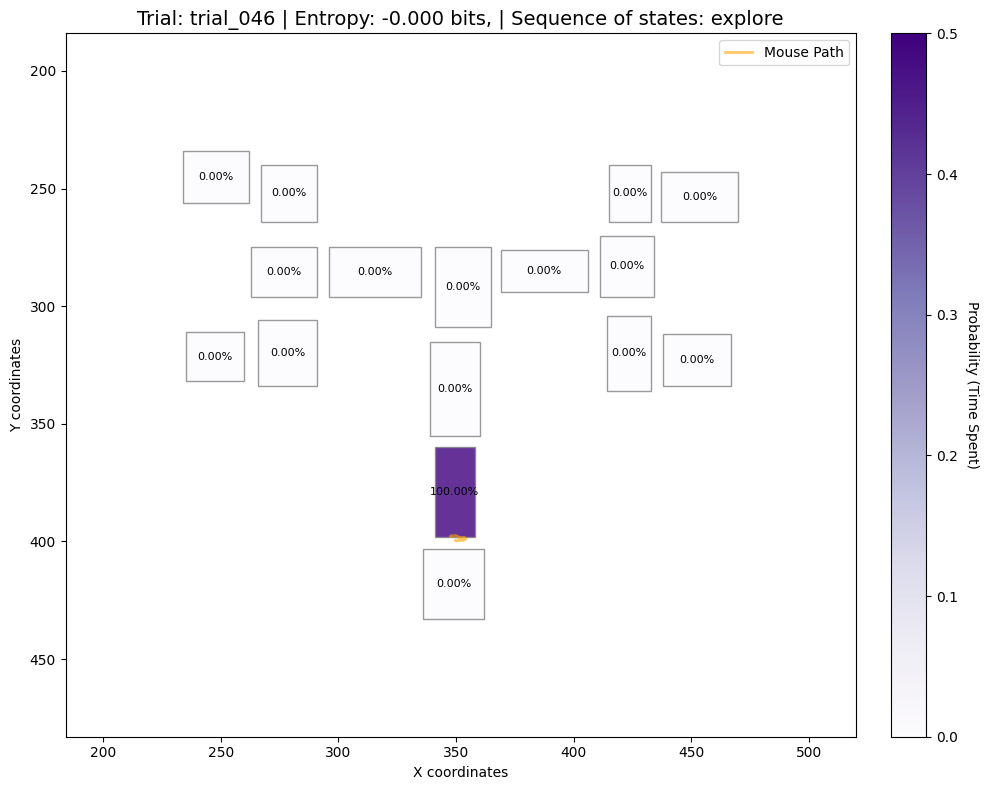

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


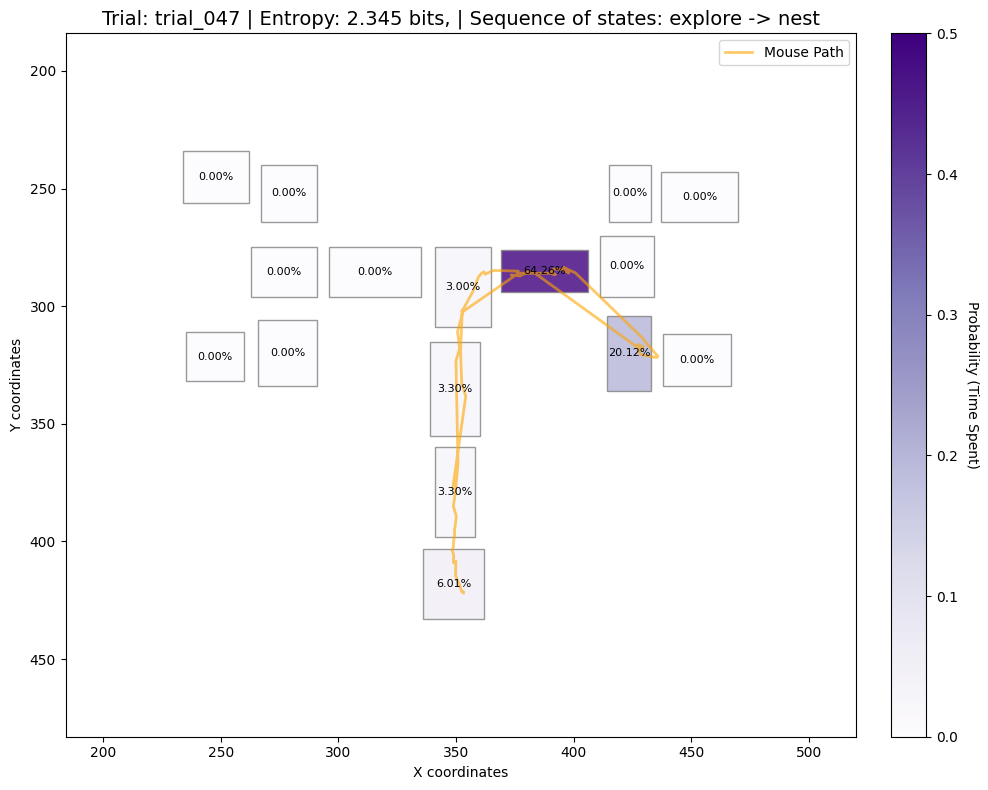

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


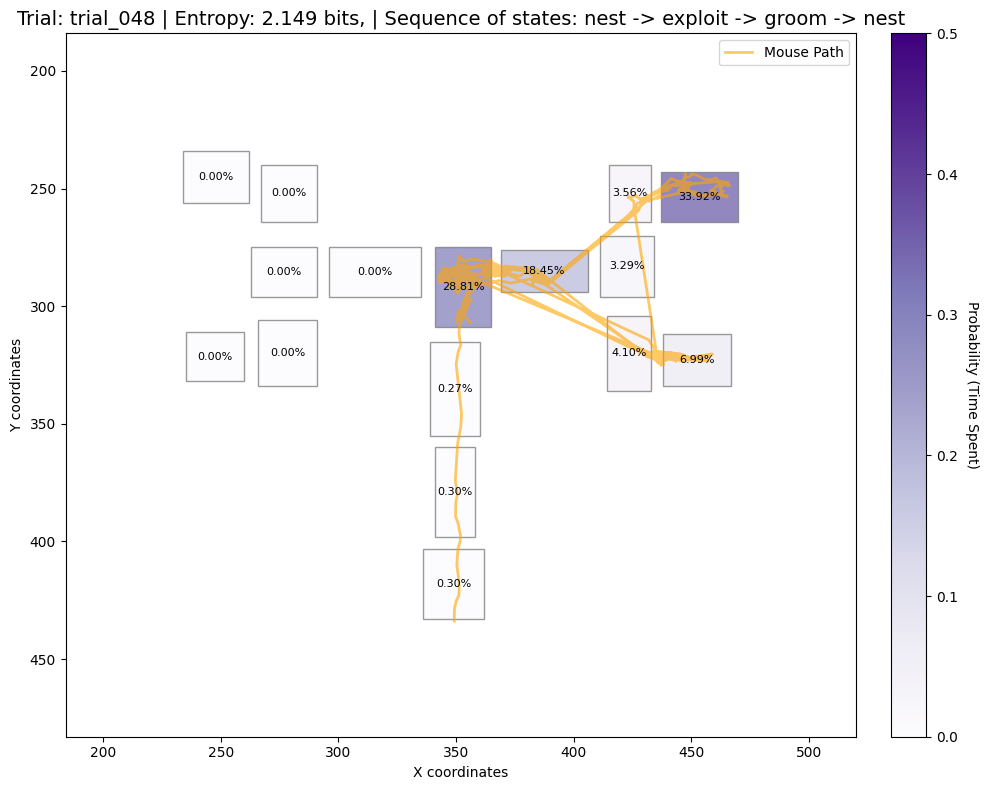

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


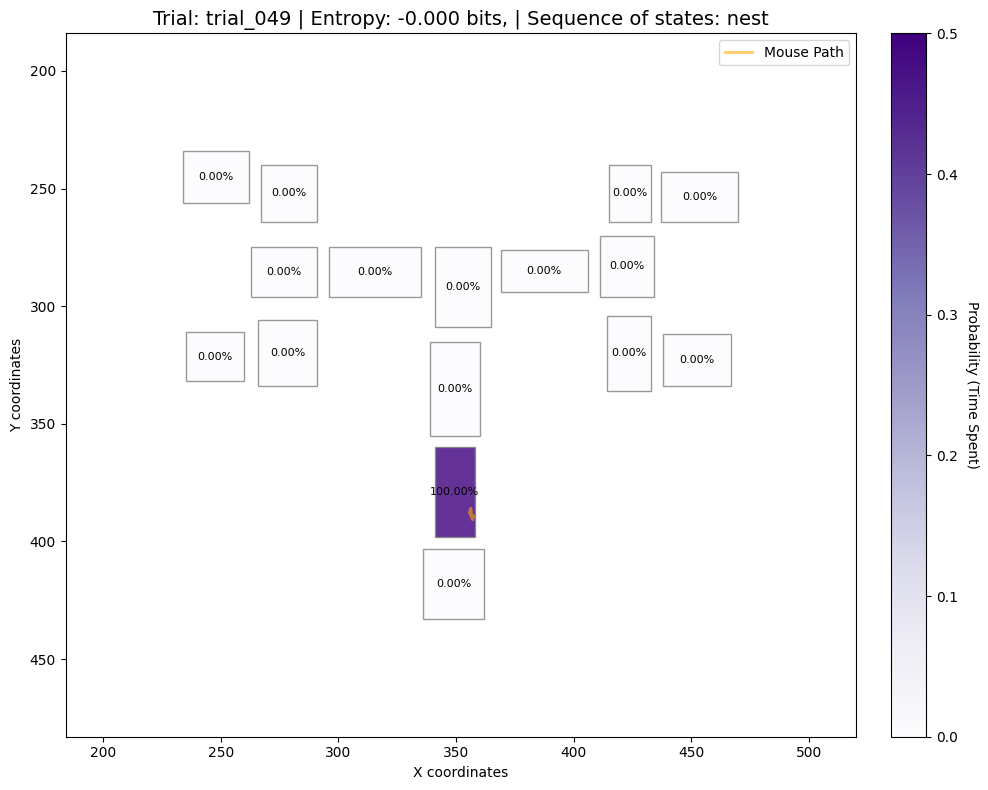

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()


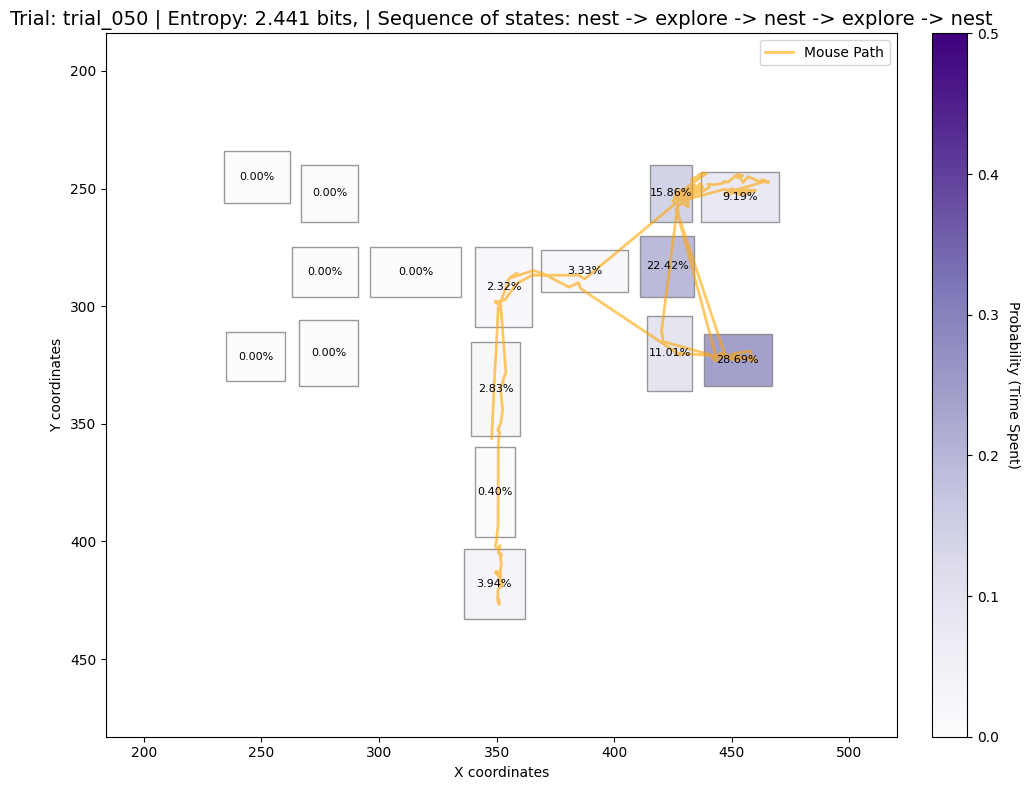

In [ ]:
# now plot, diva. Plot. 
# Example 1: Plot the first trial 
# print("Plotting Trial 0...")
# plot_spatial_heatmap(0, trials_df, dlc_df, rois)

#plot the problematic plots

for i in range(40, 60):
    try:
        plot_spatial_heatmap(i, trials_df, dlc_df, rois)
    except Exception as e:
        print(f"skipping {i} because it is null")
        continue



# # Plot the trial with the HIGHEST entropy (Maximum exploration)
# max_ent_idx = trials_df['spatial_entropy'].idxmax()
# print(f"Plotting Max Entropy Trial (Index {max_ent_idx})...")
# plot_spatial_heatmap(max_ent_idx, trials_df, dlc_df, rois)

# #  Plot the trial with the LOWEST entropy (Most focused)
# min_ent_idx = trials_df['spatial_entropy'].idxmin()
# print(f"Plotting Min Entropy Trial (Index {min_ent_idx})...")
# plot_spatial_heatmap(min_ent_idx, trials_df, dlc_df, rois)

To save the heatmaps as .png

In [49]:
def save_spatial_heatmap(row, dlc_df, rois, save_dir):

    entropy_val = row['spatial_entropy']
    raw_seq = str(row['state_sequence'])
    state_sequence_dict = {"1": "explore", "2":"exploit", "3":"nest", "4":"groom"}
    trial_id = row['matched_trial_id']

    #handle the mess with the "state_sequence" column in the df
    seq_str = "None"
    seq_for_title="None"
    if raw_seq.lower() != 'nan':
        # Split by comma to avoid reading "," as a key
        parts = [p.strip() for p in raw_seq.split(',')]
        # Map valid keys only
        mapped_parts = [state_sequence_dict.get(p, p) for p in parts if p in state_sequence_dict]
        if mapped_parts:
            seq_str = " -> ".join(mapped_parts)
            seq_for_title= "_".join(mapped_parts)
    
    
    # 1. Get Probabilities
    roi_probs = get_roi_probabilities(row, dlc_df, rois)
    
    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = cm.get_cmap('Purples') 
    norm = mcolors.Normalize(vmin=0, vmax=0.5) 

    # 3. Draw ROIs
    for name, (x1, x2, y1, y2) in rois.items():
        width = x2 - x1
        height = y2 - y1
        p = roi_probs.get(name, 0)
        color = cmap(norm(p))
        
        rect = patches.Rectangle((x1, y1), width, height, 
                                 linewidth=1, edgecolor='gray', facecolor=color, alpha=0.8)
        ax.add_patch(rect)
        
        # if p > 0.01: 
        ax.text(x1 + width/2, y1 + height/2, f"{p*100:.2f}%", 
                ha='center', va='center', fontsize=8, color='black')

    # 4. OverSlayinggg Trajectory
    try:
        start_f, end_f = int(row['start_frame']), int(row['end_frame'])
        scorer = dlc_df.columns.levels[0][0]
        #we need the clean trajectory
        x_traj, y_traj = get_cleaned_trajectory(row, dlc_df, p_cutoff=0.8)
        ax.plot(x_traj, y_traj, color='orange', linewidth=2, alpha=0.6)
    except Exception as e:
        print(f"Skipping trajectory for {trial_id} due to error: {e}")

    # 5. Styling
    ax.set_title(f"Trial: {trial_id} | Entropy: {entropy_val:.3f} bits | Sequence of States : {seq_str}")
    ax.invert_yaxis() 
    ax.set_aspect('equal')
    
    all_x = [c[0] for c in rois.values()] + [c[1] for c in rois.values()]
    all_y = [c[2] for c in rois.values()] + [c[3] for c in rois.values()]
    ax.set_xlim(min(all_x)-20, max(all_x)+20)
    ax.set_ylim(max(all_y)+20, min(all_y)-20)

    # Colourbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Probability', rotation=270, labelpad=15)
    
    # 6. SAVE AND CLOSE

    filename = f"{save_dir}/{trial_id}_{seq_for_title}_entropy_{entropy_val:.2f}.png"
    plt.savefig(filename, dpi=100)
    plt.close(fig) # Important to free memory!


In [50]:
print("Starting batch generation...")

OUTPUT_FOLDER= f"{base_path}/2024-08-28_11_58_146357session3.6/entropy_plots_threshold0.8"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

for index, row in trials_df.iterrows():
    # this is optional, but it lets us skip trials with NaN entropy or invalid frames
    if pd.isna(row['spatial_entropy']) or pd.isna(row['start_frame']):
        continue
        
    # Print progress every 10 trials
    if index % 10 == 0:
        print(f"Processing trial {index} / {len(trials_df)}...")
        
    save_spatial_heatmap(row, dlc_df, rois, OUTPUT_FOLDER)

print("Done! All plots saved.")

Starting batch generation...
Processing trial 0 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 10 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 20 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 30 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 60 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 70 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 80 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Processing trial 90 / 98...


C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples')
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\712409669.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\1579989348.py:26: M

Done! All plots saved.


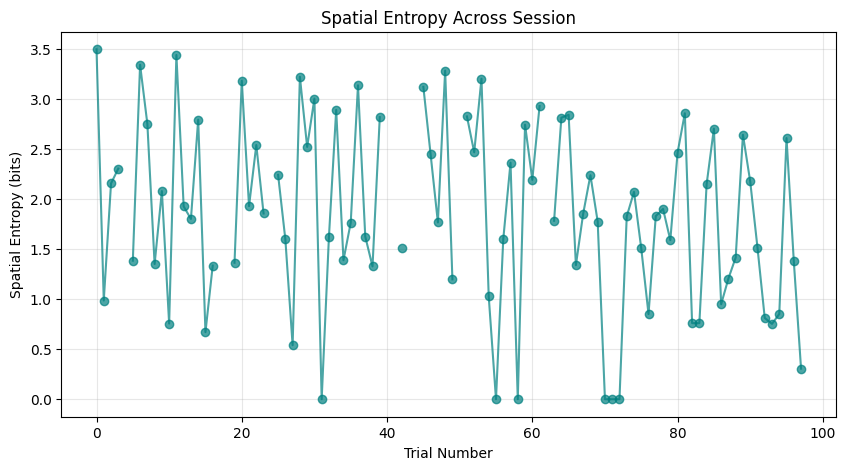

C:\Users\aleja\AppData\Local\Temp\ipykernel_47700\2285062543.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='outcome', y='spatial_entropy', data=trials_df[trials_df['outcome'] != 'Unknown'], palette="Set2")


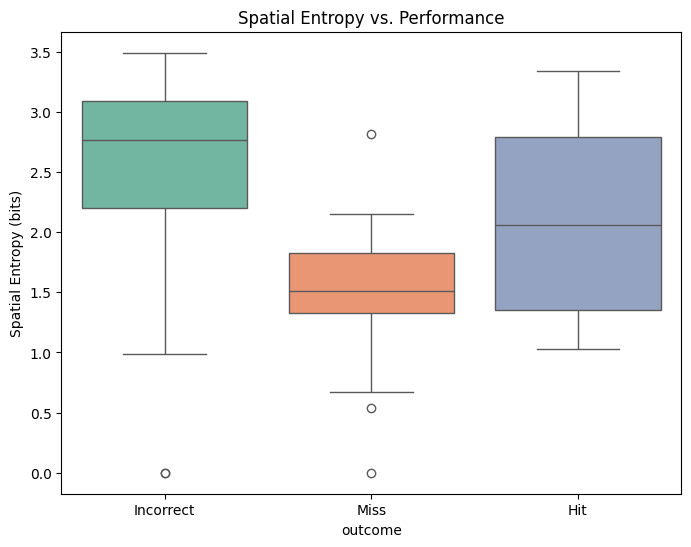

In [ ]:
import seaborn as sns
def get_cleaned_trajectory(start_f, end_f, dlc_df, bodypart='back_mid', p_cutoff=0.8):
    """
    Extracts coordinates, filters low likelihood frames, and interpolates.
    """
    if np.isnan(start_f) or np.isnan(end_f):
        return np.array([]), np.array([])
        
    start_f, end_f = int(start_f), int(end_f)
    scorer = dlc_df.columns.levels[0][0]
    
    try:
        # Extract data
        subset = dlc_df.loc[start_f:end_f, (scorer, bodypart)].copy()
        x = subset['x']
        y = subset['y']
        prob = subset['likelihood']
        
        # Filter: Set low likelihood points to NaN
        mask = prob < p_cutoff
        x[mask] = np.nan
        y[mask] = np.nan
        
        # Interpolate to fill gaps
        x_clean = x.interpolate(method='linear', limit_direction='both').values
        y_clean = y.interpolate(method='linear', limit_direction='both').values
        
        return x_clean, y_clean
    except KeyError:
        return np.array([]), np.array([])

conditions = [
    (trials_df['hit'] == 1),
    (trials_df['miss'] == 1),
    (trials_df['incorrect'] == 1)
]
choices = ['Hit', 'Miss', 'Incorrect']
trials_df['outcome'] = np.select(conditions, choices, default='Unknown')


# Plot 1: Entropy Over Time (Learning Curve)

plt.figure(figsize=(10, 5))
plt.plot(trials_df.index, trials_df['spatial_entropy'], marker='o', linestyle='-', color='teal', alpha=0.7)
plt.title('Spatial Entropy Across Session')
plt.xlabel('Trial Number')
plt.ylabel('Spatial Entropy (bits)')
plt.grid(True, alpha=0.3)
plt.show()


# Plot 2: Entropy by Outcome (Boxplot)

plt.figure(figsize=(8, 6))
sns.boxplot(x='outcome', y='spatial_entropy', data=trials_df[trials_df['outcome'] != 'Unknown'], palette="Set2")
plt.title('Spatial Entropy vs. Performance')
plt.ylabel('Spatial Entropy (bits)')
plt.show()

